In [174]:
import csv
import pandas as pd
from datetime import datetime
from Levenshtein import distance as levenshtein_distance
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statistics
from fitter import Fitter
import itertools
import multiprocessing
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import shapiro
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

In [175]:
#events_final = pd.read_csv('events_final_relativetime.csv') 
events_final = pd.read_csv('events_final.csv') 
print(events_final)

        patientid             events            starttime
0        10002013              CSURG  2160-05-18 01:49:32
1        10002013                ABG  2160-05-18 09:19:00
2        10002013                CBC  2160-05-18 09:19:00
3        10002013            Calcium  2160-05-18 09:19:00
4        10002013       Electrolytes  2160-05-18 09:19:00
...           ...                ...                  ...
127841   19995790                 SW  2185-02-05 01:00:00
127842   19995790         Metoprolol  2185-02-05 20:00:00
127843   19995790  Magnesium Sulfate  2185-02-06 02:00:00
127844   19995790       Electrolytes  2185-02-06 06:00:00
127845   19995790         Metoprolol  2185-02-06 20:00:00

[127846 rows x 3 columns]


In [176]:
events_final['starttime'] = pd.to_datetime(events_final['starttime'])

In the next step, we will start to generat the trace

In [177]:
traces = events_final.groupby('patientid')['events'].apply(list).reset_index()
traces['starttimes'] = events_final.groupby('patientid')['starttime'].apply(list).reset_index(drop=True)

In [178]:
print(traces.head())
traces.to_csv('traces.csv', index=False)

   patientid                                             events  \
0   10002013  [CSURG, ABG, CBC, Calcium, Electrolytes, Gluco...   
1   10011398  [CSURG, ABG, CBC, Calcium, Electrolytes, Gluco...   
2   10023771  [CSURG, ABG, CBC, Calcium, Electrolytes, Gluco...   
3   10033786  [CSURG, ABG, CBC, Calcium, Electrolytes, Gluco...   
4   10039688  [CSURG, ABG, CBC, Calcium, Electrolytes, Gluco...   

                                          starttimes  
0  [2160-05-18 01:49:32, 2160-05-18 09:19:00, 216...  
1  [2146-12-15 04:53:55, 2146-12-15 07:52:00, 214...  
2  [2113-08-25 03:17:43, 2113-08-25 07:29:00, 211...  
3  [2118-01-16 06:35:16, 2118-01-16 12:00:00, 211...  
4  [2147-05-31 02:31:44, 2147-05-31 07:57:00, 214...  


In [179]:
print(traces['events'].dtype)

object


In [180]:
first_line = traces.iloc[1]['events']
second_line = traces.iloc[2]['events']
print(traces.iloc[1]['events'])
print(traces.iloc[2]['events'])

['CSURG', 'ABG', 'CBC', 'Calcium', 'Electrolytes', 'Glucose', 'ABG', 'CBC', 'Electrolytes', 'Glucose', 'Aspirin', 'ABG', 'CBC', 'Electrolytes', 'Glucose', '5% Dextrose', 'Acetaminophen', 'Calcium Gluconate', 'Dextrose 50%', 'Glycopyrrolate', 'Influenza Vaccine', 'Insulin', 'Lactated Ringers', 'Magnesium Sulfate', 'Metoclopramide', 'Milk of Magnesia', 'Neostigmine', 'Nitroglycerin', 'Opioid', 'Oxycodone-Acetaminophen', 'PHENYLEPHrine', 'Pneumococcal Vaccine', 'Potassium Chloride', 'Propofol', 'Sodium Chloride 0.9%', 'Sodium Chloride 0.9%  Flush', 'Sterile Water', 'ABG', 'CBC', 'Calcium', 'Electrolytes', 'Glucose', 'CBC', 'CefazoLIN', 'Sodium Chloride 0.9%', 'Bicarbonate', 'CBC', 'Creatinine', 'Electrolytes', 'Urea Nitrogen', 'ABG', 'Calcium', 'Electrolytes', 'Glucose', 'ABG', 'Calcium', 'Electrolytes', 'Glucose', 'Ketorolac', 'ABG', 'Electrolytes', 'Glucose', 'CBC', 'Electrolytes', 'Ondansetron', 'Albumin', 'Chlorhexidine Gluconate 0.12% Oral Rinse', 'Docusate Sodium', 'Ranitidine', 'Li

In [181]:
def calculate_hamming_distance(list1, list2, pad_value=None):

    max_len = max(len(list1), len(list2))
    list1_padded = list1 + [pad_value] * (max_len - len(list1))
    list2_padded = list2 + [pad_value] * (max_len - len(list2))
    

    distance = sum(el1 != el2 for el1, el2 in zip(list1_padded, list2_padded))
    return distance

In [182]:

list1 = ['A','B','C','D']
list2 =['A','C','D']


hamming_distance_example = calculate_hamming_distance(list1, list2, pad_value='')
print(f"Hamming distance between list1 and list2: {hamming_distance_example}")

levenshtein_distance_example = levenshtein_distance(list1, list2)
print(f"levenshtein distance between list1 and list2: {levenshtein_distance_example}")

Hamming distance between list1 and list2: 3
levenshtein distance between list1 and list2: 1


In [183]:
first_line = traces.iloc[1]['events']
second_line = traces.iloc[2]['events']
print(traces.iloc[1]['events'])
print(traces.iloc[2]['events'])
print(len(traces.iloc[1]['events']))
print(len(traces.iloc[2]['events']))
hamming_distance_1_2 = calculate_hamming_distance(first_line, second_line)
levenshtein_distance_1_2 = levenshtein_distance(first_line, second_line)
print(f"Hamming distance between the first and second lines: {hamming_distance_1_2}")
print(f"Levenshtein distance between the first and second lines: {levenshtein_distance_1_2}")

['CSURG', 'ABG', 'CBC', 'Calcium', 'Electrolytes', 'Glucose', 'ABG', 'CBC', 'Electrolytes', 'Glucose', 'Aspirin', 'ABG', 'CBC', 'Electrolytes', 'Glucose', '5% Dextrose', 'Acetaminophen', 'Calcium Gluconate', 'Dextrose 50%', 'Glycopyrrolate', 'Influenza Vaccine', 'Insulin', 'Lactated Ringers', 'Magnesium Sulfate', 'Metoclopramide', 'Milk of Magnesia', 'Neostigmine', 'Nitroglycerin', 'Opioid', 'Oxycodone-Acetaminophen', 'PHENYLEPHrine', 'Pneumococcal Vaccine', 'Potassium Chloride', 'Propofol', 'Sodium Chloride 0.9%', 'Sodium Chloride 0.9%  Flush', 'Sterile Water', 'ABG', 'CBC', 'Calcium', 'Electrolytes', 'Glucose', 'CBC', 'CefazoLIN', 'Sodium Chloride 0.9%', 'Bicarbonate', 'CBC', 'Creatinine', 'Electrolytes', 'Urea Nitrogen', 'ABG', 'Calcium', 'Electrolytes', 'Glucose', 'ABG', 'Calcium', 'Electrolytes', 'Glucose', 'Ketorolac', 'ABG', 'Electrolytes', 'Glucose', 'CBC', 'Electrolytes', 'Ondansetron', 'Albumin', 'Chlorhexidine Gluconate 0.12% Oral Rinse', 'Docusate Sodium', 'Ranitidine', 'Li

In [184]:
num_elements = len(traces)
hamming_distance_matrix = pd.DataFrame(index=range(num_elements), columns=range(num_elements))

for i in range(num_elements):
    for j in range(num_elements):
        hamming_distance = calculate_hamming_distance(traces.at[i, "events"], traces.at[j, "events"])
        hamming_distance_matrix.at[i, j] = hamming_distance


print(hamming_distance_matrix)

     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
0      0  125  128  130  144  128  125  137  134  157  ...  113  134  139   
1    125    0  120  115  144  112  132  120  112  135  ...  124  118  141   
2    128  120    0  125  149  122  135  136  124  140  ...  130  130  136   
3    130  115  125    0  147  115  121  134  106  158  ...  133  134  138   
4    144  144  149  147    0  145  141  150  152  154  ...  146  148  149   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
842  132  142  140  129  147  134  131  139  143  160  ...  133  146  126   
843  157  153  150  157  155  163  159  163  168  163  ...  161  166  156   
844  120  105  124  110  147  121  135  138   94  151  ...  133  128  132   
845  158  154  153  156  153  156  157  156  157  159  ...  153  152  150   
846  135  108  138  115  153  114  136  102   95  141  ...  127   98  146   

     840  841  842  843  844  845  846  
0    136  190  132  157  120  158 

In [185]:

hamming_row_averages = hamming_distance_matrix.mean(axis=1)
print("Hamming row averages:")
print(hamming_row_averages)

Hamming row averages:
0      149.328217
1      142.005903
2      147.917355
3      143.822904
4      159.461629
          ...    
842    155.367178
843    171.695396
844    140.763872
845    166.569067
846    142.014168
Length: 847, dtype: object


In [186]:

hamming_sorted_row_averages = hamming_row_averages.sort_values(ascending=False)

hamming_reordered_matrix = hamming_distance_matrix.loc[hamming_sorted_row_averages.index]

print("Sorted row averages (descending):")
print(hamming_sorted_row_averages)

print("Reordered Hamming distance matrix:")
print(hamming_reordered_matrix)

Sorted row averages (descending):
822    973.446281
256     690.85124
450    676.247934
304    584.649351
595    576.427391
          ...    
439    139.049587
235    139.010626
656    139.009445
563    138.969303
735    138.949233
Length: 847, dtype: object
Reordered Hamming distance matrix:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
822  979  972  972  977  981  988  973  968  976  957  ...  974  971  977   
256  699  694  691  694  698  695  694  691  692  694  ...  696  688  689   
450  679  687  683  684  675  676  679  681  681  680  ...  676  684  678   
304  587  574  588  587  581  594  585  591  588  582  ...  590  584  590   
595  580  575  578  580  580  580  574  582  583  582  ...  581  581  573   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
439  132  113  124  119  138  120  138  135  105  147  ...  131  120  140   
235  126  108  122  117  140  118  136  135  102  153  ...  132  114  136   
656  131   96

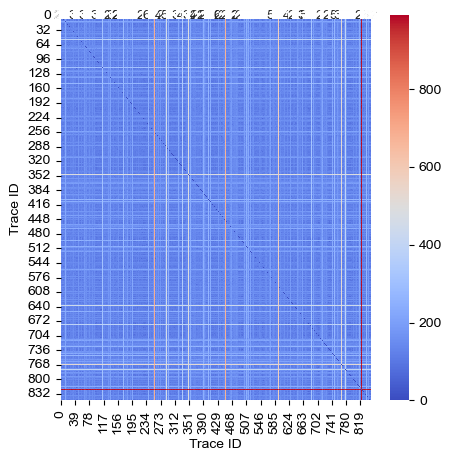

In [187]:
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(hamming_distance_matrix.astype(float), annot=True, cmap='coolwarm', fmt='g')

#plt.title('Heatmap of Hamming Distance Matrix', fontsize=12, fontweight='bold')
plt.xlabel('Trace ID', fontsize=10)
plt.ylabel('Trace ID', fontsize=10)
plt.savefig('eFigure1_Heatmap of Hamming Distance Matrix.png', format='png', dpi=300)
plt.show()

In [188]:
levenshtein_distance_matrix = pd.DataFrame(index=range(num_elements), columns=range(num_elements))


for i in range(num_elements):
    for j in range(num_elements):
        dist = levenshtein_distance(traces.at[i, "events"], traces.at[j, "events"])
        levenshtein_distance_matrix.at[i, j] = dist

print(levenshtein_distance_matrix)

     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
0      0   63   68   65   86   67   81   69   56   85  ...   69   79   78   
1     63    0   61   67   88   67   84   53   40   86  ...   64   72   87   
2     68   61    0   60   79   78   90   63   53   81  ...   53   82   83   
3     65   67   60    0   85   74   83   76   59   96  ...   67   87   80   
4     86   88   79   85    0  100  104   84   81   93  ...   77   84  108   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
842   81   90   94   89  104   80   78   89   86  100  ...  100   92   79   
843   95  108  105  100  119   92   89  105  107  110  ...  102  109   93   
844   60   49   62   66   74   71   89   50   41   80  ...   71   52   81   
845  106  105  107  115  121  118  118  114   97  128  ...  103  108  119   
846   64   49   58   58   86   72   94   62   40   88  ...   63   74   89   

     840  841  842  843  844  845  846  
0     88  133   81   95   60  106 

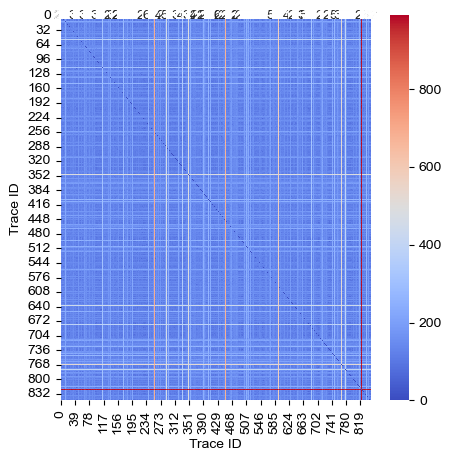

In [189]:

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(hamming_distance_matrix.astype(float), annot=True, cmap='coolwarm', fmt='g')

#plt.title('Heatmap of Levenshtein Distance Matrix', fontsize=12, fontweight='bold')
plt.xlabel('Trace ID', fontsize=10)
plt.ylabel('Trace ID', fontsize=10)
plt.savefig('eFigure2_Heatmap of Levenshtein Distance Matrix.png', format='png', dpi=300)
plt.show()

In [190]:
levenshtein_row_averages = levenshtein_distance_matrix.mean(axis=1)

print("Levenshtein row averages:")
print(levenshtein_row_averages)

Levenshtein row averages:
0       88.710744
1       86.200708
2       88.698937
3       92.855962
4       101.88902
          ...    
842    105.891381
843    116.168831
844     80.613932
845    117.420307
846      87.27745
Length: 847, dtype: object


In [191]:
levenshtein_averages = levenshtein_row_averages.tolist()
levenshtein_averages = pd.DataFrame(levenshtein_row_averages, columns=['variation distance'])
print("Levenshtein averages:")
print(levenshtein_averages)

Levenshtein averages:
    variation distance
0            88.710744
1            86.200708
2            88.698937
3            92.855962
4            101.88902
..                 ...
842         105.891381
843         116.168831
844          80.613932
845         117.420307
846           87.27745

[847 rows x 1 columns]


In [192]:

levenshtein_sorted_row_averages = levenshtein_row_averages.sort_values(ascending=False)


levenshtein_reordered_matrix = levenshtein_distance_matrix.loc[levenshtein_sorted_row_averages.index]

print("Sorted row averages (descending):")
print(levenshtein_sorted_row_averages)

print("Reordered Levenshtein distance matrix:")
print(levenshtein_reordered_matrix)

Sorted row averages (descending):
822    878.859504
256     599.22196
450    576.119244
304    491.134593
595    488.161747
          ...    
497     81.565525
141     81.327037
394     80.766234
749     80.735537
844     80.613932
Length: 847, dtype: object
Reordered Levenshtein distance matrix:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
822  878  894  876  895  888  896  877  887  902  862  ...  873  889  878   
256  603  618  598  615  604  618  603  606  619  590  ...  595  602  601   
450  574  593  574  594  573  589  577  579  594  558  ...  572  577  580   
304  494  500  485  508  486  506  493  490  506  480  ...  482  491  490   
595  492  510  488  498  494  495  475  496  512  479  ...  492  494  477   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
497   57   46   57   57   84   64   85   56   44   86  ...   65   64   84   
141   54   38   53   55   88   67   86   53   35   80  ...   59   64   75   
394   53 

In [193]:
temp_distance = levenshtein_sorted_row_averages.reset_index(drop=True)

top_2_5_percentile = np.percentile(temp_distance, 97.5)
top_5_percentile = np.percentile(temp_distance, 95)
top_10_percentile = np.percentile(temp_distance, 90)
top_20_percentile = np.percentile(temp_distance, 80)
bottom_20_percentile = np.percentile(temp_distance, 20)

print(f"Top 2.5% of the list is above: {top_2_5_percentile}")
print(f"22 th: {levenshtein_sorted_row_averages[21]}")
print(f"Top 5% of the list is above: {top_5_percentile}")
print(f"Top 10% of the list is above: {top_10_percentile}")
print(f"Top 20% of the list is above: {top_20_percentile}")
print(f"Bottom 20% of the list is below: {bottom_20_percentile}")

Top 2.5% of the list is above: 200.36558441558452
22 th: 86.49586776859505
Top 5% of the list is above: 161.46316410861854
Top 10% of the list is above: 126.75702479338841
Top 20% of the list is above: 108.68854781582054
Bottom 20% of the list is below: 88.26942148760331


In [194]:
if not levenshtein_sorted_row_averages.index.equals(hamming_sorted_row_averages.index):
    levenshtein_sorted_row_averages_positions = pd.Series(levenshtein_sorted_row_averages.index, name='levenshtein_sorted_row_averages_index')
    hamming_sorted_row_averages_positions = pd.Series(hamming_sorted_row_averages.index, name='hamming_sorted_row_averages_index')

    comparison_df = pd.DataFrame({'levenshtein_sorted_row_averages_traceid': levenshtein_sorted_row_averages_positions, 'hamming_sorted_row_averages_traceid': hamming_sorted_row_averages_positions})
    mismatched_positions = comparison_df[levenshtein_sorted_row_averages_positions != hamming_sorted_row_averages_positions]
    display(comparison_df)  
    print("Mismatched trace id:")
    display(mismatched_positions)  
else:
    print("same trace id.")

,levenshtein_sorted_row_averages_traceid,hamming_sorted_row_averages_traceid
0,822,822
1,256,256
2,450,450
3,304,304
4,595,595
...,...,...
842,497,439
843,141,235
844,394,656
845,749,563


Mismatched trace id:


,levenshtein_sorted_row_averages_traceid,hamming_sorted_row_averages_traceid
10,679,778
11,778,679
15,685,80
16,80,685
17,460,498
...,...,...
842,497,439
843,141,235
844,394,656
845,749,563


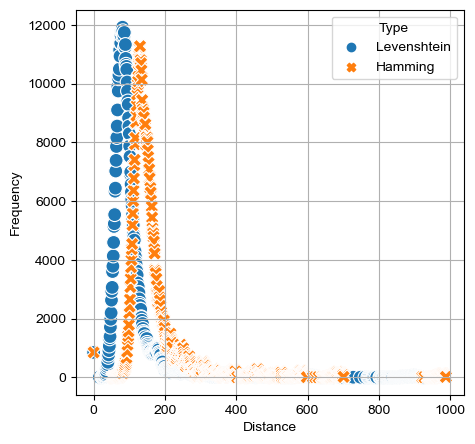

In [195]:
lev_distances = levenshtein_distance_matrix.values.flatten()
ham_distances = hamming_distance_matrix.values.flatten()

lev_unique_distances, lev_counts = np.unique(lev_distances, return_counts=True)
ham_unique_distances, ham_counts = np.unique(ham_distances, return_counts=True)

lev_distance_freq_df = pd.DataFrame({'Distance': lev_unique_distances, 'Frequency': lev_counts, 'Type': 'Levenshtein'})
ham_distance_freq_df = pd.DataFrame({'Distance': ham_unique_distances, 'Frequency': ham_counts, 'Type': 'Hamming'})

distance_freq_df = pd.concat([lev_distance_freq_df, ham_distance_freq_df])


plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=distance_freq_df, x='Distance', y='Frequency', hue='Type', style='Type', s=100)

#plt.title('Frequency Distributions of Hamming and Levenshtein Distance Measurements', fontsize=12, fontweight='bold')
plt.xlabel('Distance', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.savefig('eFigure3_Frequency Distributions of Hamming and Levenshtein Distance Measurements.png', bbox_inches='tight',format='png', dpi=300)
plt.grid(True)
plt.show()

In [196]:
#Select the top 2.5% and bottom 2.5% lists
top_2_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.025))
bottom_2_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.975))

top_2_percent_lists = levenshtein_reordered_matrix.iloc[:top_2_percent_index]
bottom_2_percent_lists = levenshtein_reordered_matrix.iloc[bottom_2_percent_index:]

In [197]:
# Select the top 5% and bottom 5% lists
top_5_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.05))
bottom_5_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.95))

top_5_percent_lists = levenshtein_reordered_matrix.iloc[:top_5_percent_index]
bottom_5_percent_lists = levenshtein_reordered_matrix.iloc[bottom_5_percent_index:]

In [198]:
# Select the top 10% and bottom 10% lists
top_10_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.10))
bottom_10_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.90))

top_10_percent_lists = levenshtein_reordered_matrix.iloc[:top_10_percent_index]
bottom_10_percent_lists = levenshtein_reordered_matrix.iloc[bottom_10_percent_index:]

In [199]:
# Select the top 20% and bottom 20% lists
top_20_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.20))
bottom_20_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.80))

top_20_percent_lists = levenshtein_reordered_matrix.iloc[:top_20_percent_index]
bottom_20_percent_lists = levenshtein_reordered_matrix.iloc[bottom_20_percent_index:]

In [200]:
print("Top 2.5% lists:")
print(top_2_percent_lists)
print("Bottom 2.5% lists:")
print(bottom_2_percent_lists)

top_2_percent_index = top_2_percent_lists.index.tolist()
print("PatientID of Top 2.5% traces:")
print(top_2_percent_lists.index.tolist())
bottom_2_percent_index = bottom_2_percent_lists.index.tolist()
print("PatientID of Bottom 2.5% traces:")
print(bottom_2_percent_lists.index.tolist())

Top 2.5% lists:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
822  878  894  876  895  888  896  877  887  902  862  ...  873  889  878   
256  603  618  598  615  604  618  603  606  619  590  ...  595  602  601   
450  574  593  574  594  573  589  577  579  594  558  ...  572  577  580   
304  494  500  485  508  486  506  493  490  506  480  ...  482  491  490   
595  492  510  488  498  494  495  475  496  512  479  ...  492  494  477   
767  425  443  419  438  421  437  421  426  438  410  ...  414  424  425   
349  396  417  396  407  391  414  397  398  414  381  ...  393  394  395   
384  365  377  365  378  374  382  366  362  380  350  ...  359  378  365   
289  352  368  353  370  349  374  358  350  364  340  ...  351  352  354   
638  351  361  348  360  357  351  342  344  365  339  ...  346  353  343   
679  297  309  291  306  293  312  299  297  307  288  ...  286  297  296   
778  290  311  291  306  298  306  296  300  314  286  ...  

In [201]:
complete_patients_clinical = pd.read_csv('completepatients.csv')
complete_patients = pd.concat([complete_patients_clinical,levenshtein_averages], axis=1)
print(complete_patients.head())

   subject_id   hadm_id  age gender insurance language                race  \
0    10002013  23581541   57      F  Medicare  ENGLISH               OTHER   
1    10011398  27505812   67      M     Other  ENGLISH  HISPANIC OR LATINO   
2    10023771  20044587   70      M  Medicare  ENGLISH               WHITE   
3    10033786  27383470   50      M     Other  ENGLISH               WHITE   
4    10039688  26345871   63      F  Medicare  ENGLISH               WHITE   

  marital_status  myocardial_infarct  congestive_heart_failure  ...  \
0         SINGLE                   1                         1  ...   
1        MARRIED                   0                         0  ...   
2        MARRIED                   0                         0  ...   
3        MARRIED                   0                         0  ...   
4        MARRIED                   1                         0  ...   

   renal_disease  malignant_cancer  severe_liver_disease  \
0              0                 0          

In [202]:
characteristics_table = pd.DataFrame({
    "Variable": ["Total patients", "Age, mean (SD)", "Gender (Female)", 
                 "Insurance (Medicare)", "Language (English)", "Race (White)", 
                 "Marital Status (Married)", "Charlson Comorbidity Index, mean (SD)", 
                 "In hospital mortality", "Died within 30 days", "Length of stay, mean (SD)"],
    "No. (%)": [
        len(complete_patients_clinical),  # Total patients
        f"{complete_patients_clinical['age'].mean():.1f} ({complete_patients_clinical['age'].std():.1f})",  
        f"{(complete_patients_clinical['gender'] == 'F').sum()} ({(complete_patients_clinical['gender'] == 'F').mean() * 100:.1f}%)", 
        f"{(complete_patients_clinical['insurance'] == 'Medicare').sum()} ({(complete_patients_clinical['insurance'] == 'Medicare').mean() * 100:.1f}%)",  
        f"{(complete_patients_clinical['language'] == 'ENGLISH').sum()} ({(complete_patients_clinical['language'] == 'ENGLISH').mean() * 100:.1f}%)",  
        f"{(complete_patients_clinical['race'] == 'WHITE').sum()} ({(complete_patients_clinical['race'] == 'WHITE').mean() * 100:.1f}%)",  
        f"{(complete_patients_clinical['marital_status'] == 'MARRIED').sum()} ({(complete_patients_clinical['marital_status'] == 'MARRIED').mean() * 100:.1f}%)",  
        f"{complete_patients_clinical['cci'].mean():.1f} ({complete_patients_clinical['cci'].std():.1f})",  
        f"{complete_patients_clinical['in_hospital_mortality'].sum()} ({complete_patients_clinical['in_hospital_mortality'].mean() * 100:.1f}%)",  
        f"{complete_patients_clinical['died_within_30_days'].sum()} ({complete_patients_clinical['died_within_30_days'].mean() * 100:.1f}%)",  
        f"{complete_patients_clinical['length_of_stay'].mean():.1f} ({complete_patients_clinical['length_of_stay'].std():.1f})"  
    ]
})
print(characteristics_table)

                                 Variable       No. (%)
0                          Total patients           847
1                          Age, mean (SD)    65.9 (9.7)
2                         Gender (Female)   146 (17.2%)
3                    Insurance (Medicare)   313 (37.0%)
4                      Language (English)   773 (91.3%)
5                            Race (White)   642 (75.8%)
6                Marital Status (Married)   600 (70.8%)
7   Charlson Comorbidity Index, mean (SD)     3.8 (2.0)
8                   In hospital mortality      7 (0.8%)
9                     Died within 30 days      9 (1.1%)
10              Length of stay, mean (SD)  140.0 (72.9)


In [203]:
#print(complete_patients.dtypes)
complete_patients['distance'] = pd.to_numeric(complete_patients['variation distance'], errors='coerce')

In [204]:
complete_patients['age_group'] = pd.cut(complete_patients['age'], bins=[20, 30, 40, 50, 60, 70, 80, 90, 100],
                         labels=['20-30', '31-40', '41-50', '51-60', '61-70','71-80','81-90','91-100'])

In [205]:
def categorize_cci(cci):
    if 10 <= cci <= 12:
        return '10-12'
    elif 8 <= cci < 10:
        return '8-10'
    elif 6 <= cci < 8:
        return '6-8'
    elif 4 <= cci < 6:  
        return '4-6'
    elif 2 <= cci < 4:  
        return '2-4'
    elif 0 <= cci < 2:
        return '0-2'
complete_patients['cci_group'] = complete_patients['cci'].apply(categorize_cci)

In [206]:
def categorize_distance(distance):
    if distance >= 108.69:  
        return 'top20%'
    else:  
        return 'Other'
complete_patients['distance_group'] = complete_patients['distance'].apply(categorize_distance)

In [207]:
print(complete_patients.head())
#complete_patients.to_csv('test.csv',index = False)
value_counts = complete_patients['distance_group'].value_counts()
print(value_counts)

   subject_id   hadm_id  age gender insurance language                race  \
0    10002013  23581541   57      F  Medicare  ENGLISH               OTHER   
1    10011398  27505812   67      M     Other  ENGLISH  HISPANIC OR LATINO   
2    10023771  20044587   70      M  Medicare  ENGLISH               WHITE   
3    10033786  27383470   50      M     Other  ENGLISH               WHITE   
4    10039688  26345871   63      F  Medicare  ENGLISH               WHITE   

  marital_status  myocardial_infarct  congestive_heart_failure  ...  aids  \
0         SINGLE                   1                         1  ...     0   
1        MARRIED                   0                         0  ...     0   
2        MARRIED                   0                         0  ...     0   
3        MARRIED                   0                         0  ...     0   
4        MARRIED                   1                         0  ...     0   

   cci  in_hospital_mortality  died_within_30_days  length_of_stay  

In [208]:
complete_patients['race'] = complete_patients['race'].str.split(' ').str[0]
complete_patients['race']= complete_patients['race'].replace(['BLACK/AFRICAN', 'BLACK/CARIBBEAN','BLACK/CAPE','HISPANIC/LATINO','HISPANIC','PATIENT', 'UNABLE','SOUTH','PORTUGUESE','MULTIPLE','OTHER','ASIAN','UNKNOWN'], 'OTHER')
value_counts_race = complete_patients['race'].value_counts()
print(value_counts_race)

race
WHITE    667
OTHER    180
Name: count, dtype: int64


In [209]:
value_counts_gender = complete_patients['gender'].value_counts()
print(value_counts_gender)
value_counts_insurance = complete_patients['insurance'].value_counts()
print(value_counts_insurance)

gender
M    701
F    146
Name: count, dtype: int64
insurance
Other       506
Medicare    313
Medicaid     28
Name: count, dtype: int64


In [210]:
y = complete_patients['length_of_stay']
model = smf.ols('y ~ distance_group + age + cci + C(gender) + C(insurance) + C(race)', data=complete_patients).fit()
print(model.summary())
residuals = model.resid
exog = model.model.exog
s, p = shapiro(residuals)
print('Shapiro-Wilk p:', p)
breuschpagan_test = het_breuschpagan(residuals, exog)
name = ['lm', 'lm_pvalue', 'fvalue', 'f_pvalue']
print(dict(zip(name, breuschpagan_test)))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     72.28
Date:                Mon, 21 Jul 2025   Prob (F-statistic):           1.01e-81
Time:                        16:14:31   Log-Likelihood:                -4634.8
No. Observations:                 847   AIC:                             9286.
Df Residuals:                     839   BIC:                             9324.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [211]:
gamma_model = smf.glm(
    formula='length_of_stay ~ distance_group + age + cci + C(gender) + C(insurance) + C(race)',
    data=complete_patients,
    family=sm.families.Gamma(link=sm.families.links.log())
).fit()

print(gamma_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         length_of_stay   No. Observations:                  847
Model:                            GLM   Df Residuals:                      839
Model Family:                   Gamma   Df Model:                            7
Link Function:                    log   Scale:                        0.082202
Method:                          IRLS   Log-Likelihood:                -4168.2
Date:                Mon, 21 Jul 2025   Deviance:                       52.097
Time:                        16:14:31   Pearson chi2:                     69.0
No. Iterations:                    12   Pseudo R-squ. (CS):             0.6251
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [212]:
np.exp(gamma_model.params)

Intercept                   144.739199
distance_group[T.top20%]      1.812068
C(gender)[T.M]                1.010070
C(insurance)[T.Medicare]      0.821839
C(insurance)[T.Other]         0.789216
C(race)[T.WHITE]              0.986718
age                           0.998514
cci                           1.032769
dtype: float64

In [213]:
np.exp(gamma_model.conf_int())

,0,1
Intercept,120.106589,174.423701
distance_group[T.top20%],1.721900,1.906957
C(gender)[T.M],0.958635,1.064265
C(insurance)[T.Medicare],0.733139,0.921270
C(insurance)[T.Other],0.706534,0.881573
C(race)[T.WHITE],0.940066,1.035685
age,0.995957,1.001078
cci,1.020091,1.045604


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


4.526111538219798e-226


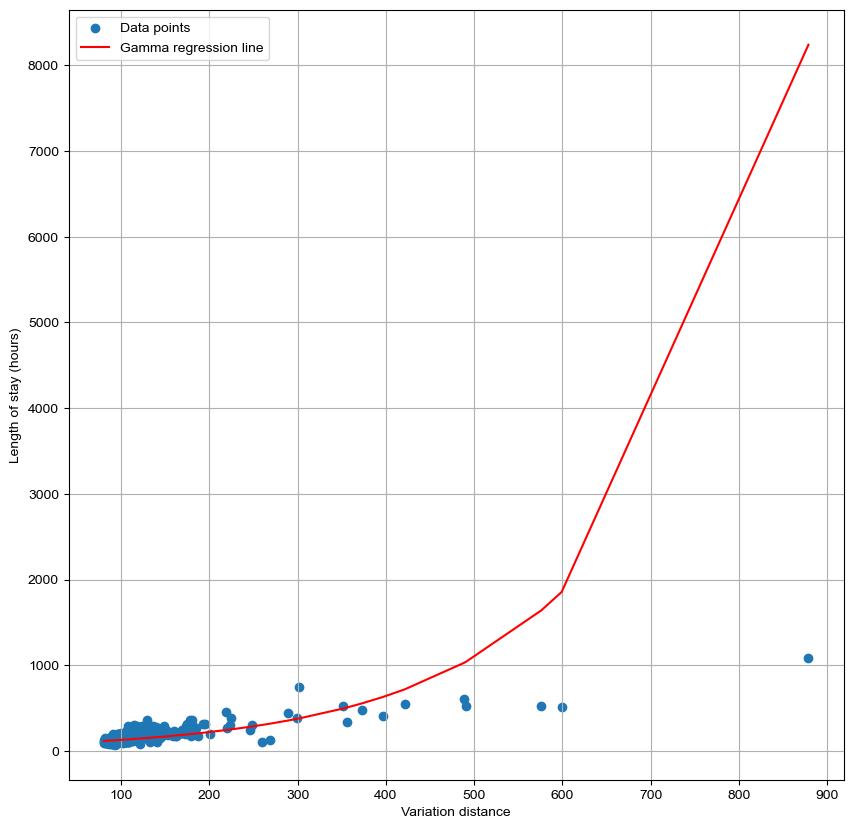

In [235]:
x = complete_patients['variation distance'].astype(float).values
#y = (complete_patients['length_of_stay'].astype(float) / 24).values

y = complete_patients['length_of_stay'].astype(float).values

X = sm.add_constant(x)

gamma_model = sm.GLM(y, X, family=sm.families.Gamma(sm.families.links.log()))
gamma_results = gamma_model.fit()


x_sorted = np.sort(x)
X_sorted = sm.add_constant(x_sorted)
y_pred = gamma_results.predict(X_sorted)


null_model = sm.GLM(y, np.ones((len(y), 1)), family=sm.families.Gamma(sm.families.links.log())).fit()
pseudo_r2 = 1 - gamma_results.deviance / null_model.deviance


p_value = gamma_results.pvalues[1]
print(p_value)

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x, y,label='Data points')
plt.plot(x_sorted, y_pred, color='red', label='Gamma regression line')

plt.xlabel('Variation distance', fontsize=10)
plt.ylabel('Length of stay (hours)', fontsize=10)
plt.grid(True)

plt.legend()
plt.savefig('Figure_Relationship Between Variation and Length of Stay.png',
            bbox_inches='tight', format='png', dpi=800)
plt.show()

In [215]:
print(complete_patients.columns)

Index(['subject_id', 'hadm_id', 'age', 'gender', 'insurance', 'language',
       'race', 'marital_status', 'myocardial_infarct',
       'congestive_heart_failure', 'peripheral_vascular_disease',
       'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease',
       'rheumatic_disease', 'peptic_ulcer_disease', 'mild_liver_disease',
       'diabetes_without_cc', 'diabetes_with_cc', 'paraplegia',
       'renal_disease', 'malignant_cancer', 'severe_liver_disease',
       'metastatic_solid_tumor', 'aids', 'cci', 'in_hospital_mortality',
       'died_within_30_days', 'length_of_stay', 'variation distance',
       'distance', 'age_group', 'cci_group', 'distance_group'],
      dtype='object')


In [216]:
top_2_percent = complete_patients.loc[top_2_percent_index]
print(top_2_percent)
output_path = 'top_2_percent.csv'
top_2_percent.to_csv(output_path, index=False)
top_2_percent_los = top_2_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_2_percent_los}")
top_2_percent_in_hospital_mortality = top_2_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_2_percent_in_hospital_mortality}")
top_2_percent_30_day_mortality = top_2_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_2_percent_30_day_mortality}")
top_2_percent_cci =top_2_percent['cci'].mean()
print(f"The average of CCI is: {top_2_percent_cci}")
top_2_percent_top3cci_averages = top_2_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_2_percent_top3cci = top_2_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_2_percent_top3cci)

     subject_id   hadm_id  age gender insurance language   race  \
822    19723798  26593663   52      M     Other  ENGLISH  WHITE   
256    13365915  29277897   82      M  Medicare  ENGLISH  WHITE   
450    15520282  23427760   72      M  Medicare  ENGLISH  WHITE   
304    13994771  25043633   81      F  Medicare  ENGLISH  WHITE   
595    17033046  21582058   82      M     Other  ENGLISH  WHITE   
767    19177655  29636680   80      M  Medicare  ENGLISH  WHITE   
349    14369707  20575513   75      F  Medicare  ENGLISH  WHITE   
384    14795403  29574331   57      M     Other  ENGLISH  WHITE   
289    13772495  24349829   75      M     Other  ENGLISH  WHITE   
638    17587573  20290742   83      M  Medicare  ENGLISH  WHITE   
679    17996934  24047037   61      F  Medicaid  ENGLISH  WHITE   
778    19359798  25190591   72      M  Medicare  ENGLISH  WHITE   
52     10710573  29923776   55      M  Medicaid        ?  OTHER   
333    14195255  27013153   74      M  Medicare  ENGLISH  WHIT

In [217]:
# Display the top 5% lists
print("Top 5% lists:")
print(top_5_percent_lists)

# Display the bottom 5% lists
print("Bottom 5% lists:")
print(bottom_5_percent_lists)

top_5_percent_index = top_5_percent_lists.index.tolist()
print("PatientID of Top 5% traces:")
print(top_5_percent_lists.index.tolist())
bottom_5_percent_index = bottom_5_percent_lists.index.tolist()
print("PatientID of Bottom 5% traces:")
print(bottom_5_percent_lists.index.tolist())

Top 5% lists:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
822  878  894  876  895  888  896  877  887  902  862  ...  873  889  878   
256  603  618  598  615  604  618  603  606  619  590  ...  595  602  601   
450  574  593  574  594  573  589  577  579  594  558  ...  572  577  580   
304  494  500  485  508  486  506  493  490  506  480  ...  482  491  490   
595  492  510  488  498  494  495  475  496  512  479  ...  492  494  477   
767  425  443  419  438  421  437  421  426  438  410  ...  414  424  425   
349  396  417  396  407  391  414  397  398  414  381  ...  393  394  395   
384  365  377  365  378  374  382  366  362  380  350  ...  359  378  365   
289  352  368  353  370  349  374  358  350  364  340  ...  351  352  354   
638  351  361  348  360  357  351  342  344  365  339  ...  346  353  343   
679  297  309  291  306  293  312  299  297  307  288  ...  286  297  296   
778  290  311  291  306  298  306  296  300  314  286  ...  28

In [218]:
# Display the top 10% lists
print("Top 10% lists:")
print(top_10_percent_lists)

# Display the bottom 10% lists
print("Bottom 10% lists:")
print(bottom_10_percent_lists)

top_10_percent_index = top_10_percent_lists.index.tolist()
print("PatientID of Top 10% traces:")
print(top_10_percent_lists.index.tolist())
bottom_10_percent_index = bottom_10_percent_lists.index.tolist()
print("PatientID of Bottom 10% traces:")
print(bottom_10_percent_lists.index.tolist())

Top 10% lists:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
822  878  894  876  895  888  896  877  887  902  862  ...  873  889  878   
256  603  618  598  615  604  618  603  606  619  590  ...  595  602  601   
450  574  593  574  594  573  589  577  579  594  558  ...  572  577  580   
304  494  500  485  508  486  506  493  490  506  480  ...  482  491  490   
595  492  510  488  498  494  495  475  496  512  479  ...  492  494  477   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
406  128  121  122  118  130  129  122  130  114  137  ...  119  128  132   
756  119  119  113  120  116  131  122  108  116  120  ...  107  106  121   
661  110  121  118  123  125  121  128  109  116  123  ...  120  112  119   
713  110  110  117  115  135  118  132  116  107  142  ...  123  121  133   
628  119  122  108  126  115  128  121  121  123  126  ...  103  116  127   

     840  841  842  843  844  845  846  
822  896  844  875 

In [219]:
# Display the top 20% lists
print("Top 20% lists:")
print(top_20_percent_lists)

# Display the bottom 20% lists
print("Bottom 20% lists:")
print(bottom_20_percent_lists)

top_20_percent_index = top_20_percent_lists.index.tolist()
print("PatientID of Top 20% traces:")
print(top_20_percent_lists.index.tolist())
bottom_20_percent_index = bottom_20_percent_lists.index.tolist()
print("PatientID of Bottom 20% traces:")
print(bottom_20_percent_lists.index.tolist())

Top 20% lists:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
822  878  894  876  895  888  896  877  887  902  862  ...  873  889  878   
256  603  618  598  615  604  618  603  606  619  590  ...  595  602  601   
450  574  593  574  594  573  589  577  579  594  558  ...  572  577  580   
304  494  500  485  508  486  506  493  490  506  480  ...  482  491  490   
595  492  510  488  498  494  495  475  496  512  479  ...  492  494  477   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
619   80   93   76   71  103   85   93   97   92  104  ...   86  105   84   
738   91   90   90   98   88   99  107   97   92  100  ...   84   87  109   
480   92   98   86  100  102   94   94   86   93  102  ...   92   93   97   
184  103   98  102  108   96  111  107   98   97  114  ...   99   93  118   
403   86   99   87   84  109   89   88   92   97  104  ...   83  107   85   

     840  841  842  843  844  845  846  
822  896  844  875 

In [220]:
top_5_percent = complete_patients.loc[top_5_percent_index]
output_path = 'top_5_percent.csv'
top_5_percent.to_csv(output_path, index=False)
top_5_percent_los = top_5_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_5_percent_los}")
top_5_percent_in_hospital_mortality = top_5_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_5_percent_in_hospital_mortality}")
top_5_percent_30_day_mortality = top_5_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_5_percent_30_day_mortality}")
top_5_percent_cci =top_5_percent['cci'].mean()
print(f"The average of CCI is: {top_5_percent_cci}")
top_5_percent_top3cci_averages = top_5_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_5_percent_top3cci = top_5_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_5_percent_top3cci)

The average of LOS is: 342.3996124031008
The average of in_hospital_mortality is: 0.13953488372093023
The average of 30_day_mortality is: 0.13953488372093023
The average of CCI is: 5.465116279069767
Top3 CCI:
diabetes_without_cc            0.395349
peripheral_vascular_disease    0.372093
chronic_pulmonary_disease      0.372093
dtype: float64


In [221]:
top_10_percent = complete_patients.loc[top_10_percent_index]
output_path = 'top_10_percent.csv'
top_10_percent.to_csv(output_path, index=False)
top_10_percent_los = top_10_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_10_percent_los}")
top_10_percent_in_hospital_mortality = top_10_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_10_percent_in_hospital_mortality}")
top_10_percent_30_day_mortality = top_10_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_10_percent_30_day_mortality}")
top_10_percent_cci =top_10_percent['cci'].mean()
print(f"The average of CCI is: {top_10_percent_cci}")
top_10_percent_top3cci_averages = top_10_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_10_percent_top3cci = top_10_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_10_percent_top3cci)

The average of LOS is: 279.2613725490196
The average of in_hospital_mortality is: 0.07058823529411765
The average of 30_day_mortality is: 0.07058823529411765
The average of CCI is: 5.447058823529412
Top3 CCI:
diabetes_without_cc          0.423529
chronic_pulmonary_disease    0.352941
renal_disease                0.341176
dtype: float64


In [222]:
top_20_percent = complete_patients.loc[top_20_percent_index]
output_path = 'top_20_percent.csv'
top_20_percent.to_csv(output_path, index=False)
top_20_percent_los = top_20_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_20_percent_los}")
top_20_percent_in_hospital_mortality = top_20_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_20_percent_in_hospital_mortality}")
top_20_percent_30_day_mortality = top_20_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_20_percent_30_day_mortality}")
top_20_percent_cci =top_20_percent['cci'].mean()
print(f"The average of CCI is: {top_20_percent_cci}")
top_20_percent_top3cci_averages = top_20_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_20_percent_top3cci = top_20_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_20_percent_top3cci)

The average of LOS is: 225.9286274509804
The average of in_hospital_mortality is: 0.041176470588235294
The average of 30_day_mortality is: 0.041176470588235294
The average of CCI is: 4.958823529411765
Top3 CCI:
diabetes_without_cc          0.370588
myocardial_infarct           0.317647
chronic_pulmonary_disease    0.294118
dtype: float64


In [223]:
bottom_5_percent = complete_patients.loc[bottom_5_percent_index]
output_path = 'bottom_5_percent.csv'
bottom_5_percent.to_csv(output_path, index=False)
bottom_5_percent_los = bottom_5_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_5_percent_los}")
bottom_5_percent_in_hospital_mortality = bottom_5_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_5_percent_in_hospital_mortality}")
bottom_5_percent_30_day_mortality = bottom_5_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_5_percent_30_day_mortality}")
bottom_5_percent_cci =bottom_5_percent['cci'].mean()
print(f"The average of CCI is: {bottom_5_percent_cci}")

bottom_5_percent_top3cci_averages = bottom_5_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_5_percent_top3cci = bottom_5_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_5_percent_top3cci)

The average of LOS is: 108.00077519379843
The average of in_hospital_mortality is: 0.0
The average of 30_day_mortality is: 0.0
The average of CCI is: 3.046511627906977
Top3 CCI:
diabetes_without_cc          0.255814
myocardial_infarct           0.186047
chronic_pulmonary_disease    0.116279
dtype: float64


In [224]:
bottom_10_percent = complete_patients.loc[bottom_10_percent_index]
output_path = 'bottom_10_percent.csv'
bottom_10_percent.to_csv(output_path, index=False)
bottom_10_percent_los = bottom_10_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_10_percent_los}")
bottom_10_percent_in_hospital_mortality = bottom_10_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_10_percent_in_hospital_mortality}")
bottom_10_percent_30_day_mortality = bottom_10_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_10_percent_30_day_mortality}")
bottom_10_percent_cci =bottom_10_percent['cci'].mean()
print(f"The average of CCI is: {bottom_10_percent_cci}")

bottom_10_percent_top3cci_averages = bottom_10_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_10_percent_top3cci = bottom_10_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_10_percent_top3cci)

The average of LOS is: 109.55568627450981
The average of in_hospital_mortality is: 0.0
The average of 30_day_mortality is: 0.0
The average of CCI is: 3.011764705882353
Top3 CCI:
diabetes_without_cc          0.305882
myocardial_infarct           0.200000
chronic_pulmonary_disease    0.105882
dtype: float64


In [225]:
bottom_20_percent = complete_patients.loc[bottom_20_percent_index]
output_path = 'bottom_20_percent.csv'
bottom_20_percent.to_csv(output_path, index=False)
bottom_20_percent_los = bottom_20_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_20_percent_los}")
bottom_20_percent_in_hospital_mortality = bottom_20_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_20_percent_in_hospital_mortality}")
bottom_20_percent_30_day_mortality = bottom_20_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_20_percent_30_day_mortality}")
bottom_20_percent_cci =bottom_20_percent['cci'].mean()
print(f"The average of CCI is: {bottom_20_percent_cci}")

bottom_20_percent_top3cci_averages = bottom_20_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_20_percent_top3cci = bottom_20_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_20_percent_top3cci)

The average of LOS is: 109.1478431372549
The average of in_hospital_mortality is: 0.0
The average of 30_day_mortality is: 0.0
The average of CCI is: 2.9823529411764707
Top3 CCI:
diabetes_without_cc          0.300000
myocardial_infarct           0.223529
chronic_pulmonary_disease    0.100000
dtype: float64


In [226]:
#X = complete_patients[['age','cci','myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']]

In [227]:
traces_top_2_percent = traces.iloc[top_2_percent_index]
top_2_percent_patient = traces_top_2_percent['patientid']
print(top_2_percent_patient)
events_final_top_2_percent = events_final[events_final['patientid'].isin(top_2_percent_patient)]
print(events_final_top_2_percent)
events_final_top_2_percent.to_csv('events_final_top_2_percent.csv', index=False)

822    19723798
256    13365915
450    15520282
304    13994771
595    17033046
767    19177655
349    14369707
384    14795403
289    13772495
638    17587573
679    17996934
778    19359798
52     10710573
333    14195255
364    14603993
685    18083865
80     11076206
460    15610823
498    16035306
157    12109233
114    11464841
170    12253915
Name: patientid, dtype: int64
        patientid         events           starttime
7386     10710573          CSURG 2114-04-17 01:33:36
7387     10710573            ABG 2114-04-17 08:26:00
7388     10710573            CBC 2114-04-17 08:26:00
7389     10710573        Calcium 2114-04-17 08:26:00
7390     10710573   Electrolytes 2114-04-17 08:26:00
...           ...            ...                 ...
124294   19723798   Electrolytes 2151-01-26 01:30:00
124295   19723798        Glucose 2151-01-26 01:30:00
124296   19723798  Urea Nitrogen 2151-01-26 01:30:00
124297   19723798     Ranitidine 2151-01-26 08:00:00
124298   19723798      Lorazepam 21

In [228]:
traces_top_5_percent = traces.iloc[top_5_percent_index]
top_5_percent_patient = traces_top_5_percent['patientid']
print(top_5_percent_patient)
events_final_top_5_percent = events_final[events_final['patientid'].isin(top_5_percent_patient)]
print(events_final_top_5_percent)
events_final_top_5_percent.to_csv('events_final_top_5_percent.csv', index=False)

822    19723798
256    13365915
450    15520282
304    13994771
595    17033046
767    19177655
349    14369707
384    14795403
289    13772495
638    17587573
679    17996934
778    19359798
52     10710573
333    14195255
364    14603993
685    18083865
80     11076206
460    15610823
498    16035306
157    12109233
114    11464841
170    12253915
149    12001282
172    12288757
728    18669132
404    14981236
748    18942549
835    19872834
12     10135595
383    14790760
390    14851532
508    16151940
495    16006577
295    13801654
816    19674244
651    17672672
240    13139482
395    14908025
449    15502607
409    15022453
743    18906801
513    16199860
468    15737972
Name: patientid, dtype: int64
        patientid                       events           starttime
1624     10135595                        CSURG 2122-04-01 00:11:48
1625     10135595                      Aspirin 2122-04-01 08:00:00
1626     10135595             Milk of Magnesia 2122-04-01 08:00:00
1627     10135

In [229]:
traces_bottom_20_percent = traces.iloc[bottom_20_percent_index]
bottom_20_percent_patient = traces_bottom_20_percent['patientid']
print(bottom_20_percent_patient)
events_final_bottom_20_percent = events_final[events_final['patientid'].isin(bottom_20_percent_patient)]
print(events_final_bottom_20_percent)
events_final_bottom_20_percent.to_csv('events_final_bottom_20_percent.csv', index=False)

95     11164976
665    17806254
702    18270760
285    13750451
515    16203126
         ...   
497    16019747
141    11910483
394    14884188
749    18948626
844    19975223
Name: patientid, Length: 170, dtype: int64
        patientid             events           starttime
139      10011398              CSURG 2146-12-15 04:53:55
140      10011398                ABG 2146-12-15 07:52:00
141      10011398                CBC 2146-12-15 07:52:00
142      10011398            Calcium 2146-12-15 07:52:00
143      10011398       Electrolytes 2146-12-15 07:52:00
...           ...                ...                 ...
127841   19995790                 SW 2185-02-05 01:00:00
127842   19995790         Metoprolol 2185-02-05 20:00:00
127843   19995790  Magnesium Sulfate 2185-02-06 02:00:00
127844   19995790       Electrolytes 2185-02-06 06:00:00
127845   19995790         Metoprolol 2185-02-06 20:00:00

[19851 rows x 3 columns]


In [230]:
traces_top_20_percent = traces.iloc[top_20_percent_index]
top_20_percent_patient = traces_top_20_percent['patientid']
print(top_20_percent_patient)
events_final_top_20_percent = events_final[events_final['patientid'].isin(top_20_percent_patient)]
print(events_final_top_20_percent)
events_final_top_20_percent.to_csv('events_final_top_20_percent.csv', index=False)

822    19723798
256    13365915
450    15520282
304    13994771
595    17033046
         ...   
619    17378719
738    18843461
480    15837207
184    12445879
403    14974584
Name: patientid, Length: 170, dtype: int64
        patientid                       events           starttime
1624     10135595                        CSURG 2122-04-01 00:11:48
1625     10135595                      Aspirin 2122-04-01 08:00:00
1626     10135595             Milk of Magnesia 2122-04-01 08:00:00
1627     10135595  Sodium Chloride 0.9%  Flush 2122-04-01 08:00:00
1628     10135595                          ABG 2122-04-01 10:56:00
...           ...                          ...                 ...
127734   19978774                   Creatinine 2128-09-30 06:10:00
127735   19978774                 Electrolytes 2128-09-30 06:10:00
127736   19978774                      Glucose 2128-09-30 06:10:00
127737   19978774                Urea Nitrogen 2128-09-30 06:10:00
127738   19978774                    Lorazep